In [1]:
#import dependencies 
import pandas as pd
import numpy as np
import json
from collections import Counter
from pprint import pprint
import requests
import os 
import csv 
from datetime import datetime
from xgboost import XGBRegressor
from config import api_key

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#make all columns visible
pd.set_option('display.max_columns', None)

In [4]:
#Import Datasets from Kaggle
train_data = pd.read_csv('Resources/Merged_Frames.csv')

In [5]:
#check to see how many missing values each potential feature has
train_data.isna().sum().sort_values(ascending=False)

belongs_to_collection    6371
homepage                 5412
tagline                  1544
Keywords                  700
production_companies      415
production_countries      155
spoken_languages           57
crew                       38
cast                       26
overview                   26
genres                     21
runtime                     4
poster_path                 2
status                      2
release_date                1
title                       0
Unnamed: 0                  0
id                          0
popularity                  0
original_title              0
original_language           0
imdb_id                     0
budget                      0
revenue                     0
dtype: int64

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8019 entries, 0 to 8018
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             8019 non-null   int64  
 1   id                     8019 non-null   int64  
 2   belongs_to_collection  1648 non-null   object 
 3   budget                 8019 non-null   int64  
 4   genres                 7998 non-null   object 
 5   homepage               2607 non-null   object 
 6   imdb_id                8019 non-null   object 
 7   original_language      8019 non-null   object 
 8   original_title         8019 non-null   object 
 9   overview               7993 non-null   object 
 10  popularity             8019 non-null   float64
 11  poster_path            8017 non-null   object 
 12  production_companies   7604 non-null   object 
 13  production_countries   7864 non-null   object 
 14  release_date           8018 non-null   object 
 15  runt

In [7]:
train_data.drop(train_data.columns[train_data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [8]:
train_data.describe()

,id,budget,popularity,runtime,revenue
count,8019.000000,8.019000e+03,8019.000000,8015.000000,8.019000e+03
mean,3815.390947,2.312810e+07,8.691725,107.830069,7.265194e+07
std,2125.298315,3.727946e+07,11.844729,20.950417,1.494375e+08
min,1.000000,0.000000e+00,0.000001,0.000000,0.000000e+00
25%,2005.500000,0.000000e+00,4.126906,94.000000,2.673732e+06
50%,3847.000000,8.000000e+06,7.612498,104.000000,1.866203e+07
75%,5653.500000,3.000000e+07,11.111726,118.000000,7.273936e+07
max,7398.000000,3.800000e+08,547.488298,338.000000,2.847246e+09


In [9]:
#so many 0 values for budget
len(train_data[train_data['budget'] == 0])

2117

In [10]:
len(train_data[train_data['runtime'] == 0])

20

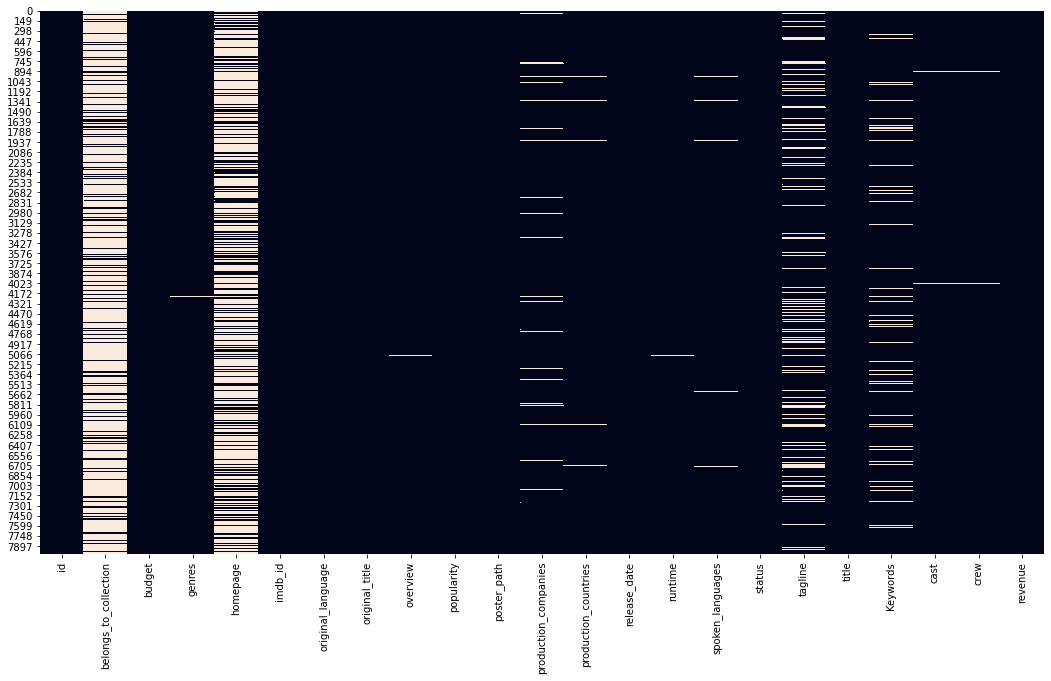

In [11]:
#lets look at all the null columns in our dataset 
plt.figure(figsize = (18,10))
sns.heatmap(train_data.isnull() , cbar = False)

plt.savefig('show_null.pdf') 

# Addressing each Feature w/ Feature Engineering

# Belongs_to_collection

In [12]:
print(train_data.loc[0]['belongs_to_collection'])
print(train_data.loc[1]['belongs_to_collection'])

[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
[{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]


Text(0, 0.5, 'revenue')

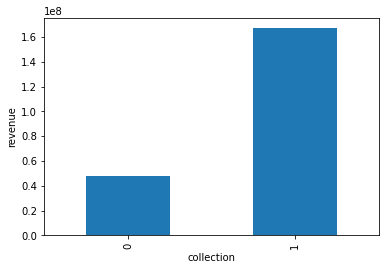

In [13]:
#the 'name' key in the dictionary describes what 'collection' each film belongs to 
# we will assume that if a film has a null in this column that it does NOT belong to a collection
# lets see if there is a correlation between belonging to a collection and the film's revenue
#create a column called collection which will  have a value 1 if the movie belongs to any collection 
#and 0 if it does not belong to any collection.
train_data['collection'] = np.where(train_data['belongs_to_collection'].isnull() , 0 , 1)
train_data.groupby(by = 'collection')['revenue'].mean().plot.bar()
plt.ylabel('revenue')

belong_to_collection conclusion: Films that belong to a collection often have a higher revenue

# Genres

In [14]:
import ast

In [15]:
#to extract the genre from each dictionary, we will need to perform json parsing 
genre_df= train_data.copy()
genre = set()
for i in genre_df.index:
    if str(genre_df.loc[i]['genres']) != 'nan':
        genres = ast.literal_eval(genre_df.loc[i]['genres'])
        for j in range(len(genres)):
            genre_df.at[i,genres[j]['name']] = 1
            genre.add(genres[j]['name'])   

In [16]:
genre_revenue = {}
for genre in genre:
    revenue = genre_df[genre_df[genre] == 1]['revenue'].mean()
    genre_revenue.update({genre:revenue})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'Western'),
  Text(1, 0, 'Family'),
  Text(2, 0, 'Thriller'),
  Text(3, 0, 'Music'),
  Text(4, 0, 'Animation'),
  Text(5, 0, 'War'),
  Text(6, 0, 'History'),
  Text(7, 0, 'Documentary'),
  Text(8, 0, 'Romance'),
  Text(9, 0, 'Foreign'),
  Text(10, 0, 'Mystery'),
  Text(11, 0, 'Adventure'),
  Text(12, 0, 'TV Movie'),
  Text(13, 0, 'Crime'),
  Text(14, 0, 'Drama'),
  Text(15, 0, 'Science Fiction'),
  Text(16, 0, 'Fantasy'),
  Text(17, 0, 'Comedy'),
  Text(18, 0, 'Action'),
  Text(19, 0, 'Horror')])

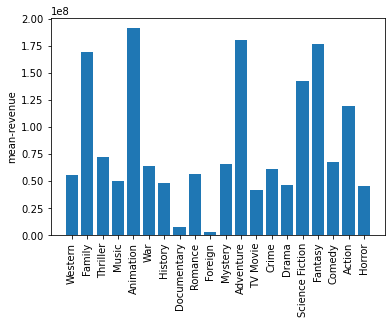

In [17]:
genre_list = list(genre_revenue.keys())
revenue = list(genre_revenue.values())
plt.bar(range(len(genre_revenue)),revenue, tick_label=genre_list)
plt.ylabel('mean-revenue')
plt.xticks(rotation = 90)

Interesting that animation has the highest mean revenue

In [18]:
genre = set()
for i in train_data.index:
    if str(train_data.loc[i]['genres']) != 'nan':
        genres = ast.literal_eval(train_data.loc[i]['genres'])
        for j in range(len(genres)):
            train_data.at[i,genres[j]['name']] = 1
            genre.add(genres[j]['name'])   

In [19]:
genre = np.array(list(genre))

In [20]:
train_data[genre] = np.where(train_data[genre].isnull(), 0 , 1)

# Homepage
similar to the belongs_to_collection feature, we will assume that if a film is null in this category, that means it does not have a page dedicated to it on TMDB. To keep this information in our dataframe, we will ad a has_homepage column and make 1 for yes and 0 for no

In [21]:
train_data['is_homepage'] = np.where(train_data['homepage'].isnull() , 0 , 1)

# Original Language
For this feature we will most likely need to use onehotencoding. However if the majority of original_languages = en, we could possible create a new column for english 1 for yes 0 for no

In [22]:
len(train_data[train_data['original_language'] == 'en'])

6931

In [23]:
#above confirms that we should make a column called is_original_language_english which will have value 1 
train_data['is_original_language_english'] = np.where(train_data['original_language'] == 'en' , 1 , 0)

# Spoken Languages

In [24]:
#json parse out language from dictionary, similar to genre column
lang_df = train_data.copy()
spoken_languages = set()
number_of_spoken_languages = []
for i in lang_df.index:
    if str(lang_df.loc[i]['spoken_languages']) != 'nan':
        languages = ast.literal_eval(lang_df.loc[i]['spoken_languages'])
        number_of_spoken_languages.append(len(languages))
        for j in range(len(languages)):
            lang_df.at[i,languages[j]['name']] = 1
            spoken_languages.add(languages[j]['name'])
    else:
        number_of_spoken_languages.append(0)

In [25]:
languages_revenue = {}

for languages in spoken_languages:
    if languages != '':
        revenue = lang_df[lang_df[languages] == 1]['revenue'].mean()
        languages_revenue.update({languages:revenue})

In [26]:
language_list = list(languages_revenue.keys())
revenue = list(languages_revenue.values())

Text(0, 0.5, 'mean revenue')

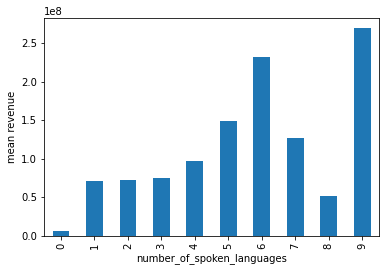

In [27]:
lang_df['number_of_spoken_languages'] = number_of_spoken_languages
lang_df.groupby(by = 'number_of_spoken_languages')['revenue'].mean().plot.bar()
plt.ylabel('mean revenue')

In [28]:
#on top of of get_dummies for every language, we will include a column that indicates the number of languages 0-9
for i in train_data.index:
    if str(train_data.loc[i]['spoken_languages']) != 'nan':
        languages = ast.literal_eval(train_data.loc[i]['spoken_languages'])
        for j in range(len(languages)):
            train_data.at[i,languages[j]['name']] = 1
spoken_languages = np.array(list(spoken_languages))
train_data[spoken_languages] = np.where(train_data[spoken_languages].isnull() , 0 , 1)
train_data['numer_of_spoken_languages'] = number_of_spoken_languages

In [29]:
train_data.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection,Comedy,Drama,Family,Romance,Thriller,Action,Animation,Adventure,Horror,Documentary,Music,Crime,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,TV Movie,is_homepage,is_original_language_english,English,हिन्दी,한국어/조선말,العربية,Pусский,svenska,Srpski,Deutsch,Français,Italiano,日本語,עִבְרִית,Português,Latin,普通话,Español,Nederlands,广州话 / 廣州話,,Český,தமிழ்,తెలుగు,Polski,Türkçe,Magyar,ελληνικά,Gaeilge,فارسی,ภาษาไทย,Català,Dansk,বাংলা,қазақ,Afrikaans,ਪੰਜਾਬੀ,български език,Kiswahili,Norsk,No Language,suomi,اردو,shqip,Română,Bahasa indonesia,Tiếng Việt,Slovenčina,Український,Esperanto,euskera,isiZulu,Somali,Íslenska,Wolof,Eesti,پښتو,Hrvatski,ქართული,Bosanski,Bamanankan,Galego,Cymraeg,?????,Malti,numer_of_spoken_languages
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,

# Production Country

In [30]:
train_data['production_countries'].unique()

array(["[{'iso_3166_1': 'US', 'name': 'United States of America'}]",
       "[{'iso_3166_1': 'IN', 'name': 'India'}]",
       "[{'iso_3166_1': 'KR', 'name': 'South Korea'}]", nan,
       "[{'iso_3166_1': 'US', 'name': 'United States of America'}, {'iso_3166_1': 'CA', 'name': 'Canada'}]",
       "[{'iso_3166_1': 'RS', 'name': 'Serbia'}]",
       "[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",
       "[{'iso_3166_1': 'AT', 'name': 'Austria'}, {'iso_3166_1': 'DE', 'name': 'Germany'}, {'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",
       "[{'iso_3166_1': 'FR', 'name': 'France'}]",
       "[{'iso_3166_1': 'NZ', 'name': 'New Zealand'}]",
       "[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]",
       "[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso_3166_1': 'IE', 'name': 'Ireland'}]",
       "[{'iso_3166_1': 'AT', 'name': 'Austria'}, {'iso_3166_1': 'FR', 'name': 'France'}, {'iso_3166_1': 'DE', 'name': 'Germany'}, {'iso_3166_1': 'IT', '

In [31]:
number_of_pc = []
 
pc_df = train_data.copy()    
for i in pc_df.index:
    if str(pc_df.loc[i]['production_countries']) != 'nan':
        production_country = ast.literal_eval(pc_df.loc[i]['production_countries'])
        number_of_pc.append(len(production_country))
        a = -1
        for j in range(len(production_country)):
            if production_country[j]['iso_3166_1'] == 'US':
                pc_df.at[i,'is_production_country_US'] = 1
                a = 0
        if a == -1:
            pc_df.at[i,'is_production_country_US'] = 0
    else:
        number_of_pc.append(0)
        pc_df.at[i,'is_production_country_US'] = 0
            

Text(0, 0.5, 'mean revenue')

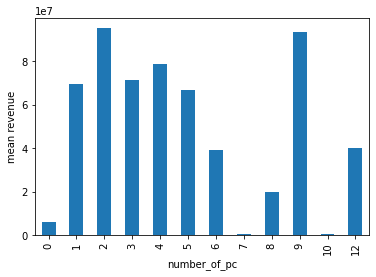

In [32]:
pc_df['number_of_pc'] = number_of_pc
pc_df.groupby(by = 'number_of_pc')['revenue'].mean().plot.bar()
plt.ylabel('mean revenue')

<AxesSubplot:xlabel='is_production_country_US'>

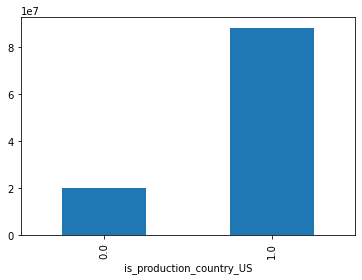

In [33]:
#interesting distribution, no real pattern
#lets see how movies made in the US affect revenue
pc_df.groupby(by = 'is_production_country_US')['revenue'].mean().plot.bar()

In [34]:
train_data['number_of_pc'] = number_of_pc
train_data['is_production_country_US'] = pc_df['is_production_country_US']

In [35]:
train_data.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection,Comedy,Drama,Family,Romance,Thriller,Action,Animation,Adventure,Horror,Documentary,Music,Crime,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,TV Movie,is_homepage,is_original_language_english,English,हिन्दी,한국어/조선말,العربية,Pусский,svenska,Srpski,Deutsch,Français,Italiano,日本語,עִבְרִית,Português,Latin,普通话,Español,Nederlands,广州话 / 廣州話,,Český,தமிழ்,తెలుగు,Polski,Türkçe,Magyar,ελληνικά,Gaeilge,فارسی,ภาษาไทย,Català,Dansk,বাংলা,қазақ,Afrikaans,ਪੰਜਾਬੀ,български език,Kiswahili,Norsk,No Language,suomi,اردو,shqip,Română,Bahasa indonesia,Tiếng Việt,Slovenčina,Український,Esperanto,euskera,isiZulu,Somali,Íslenska,Wolof,Eesti,پښتو,Hrvatski,ქართული,Bosanski,Bamanankan,Galego,Cymraeg,?????,Malti,numer_of_spoken_languages,number_of_pc,is_production_country_US
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,0,0,1,0,0,

# Release Date
Need to space out date column 

In [36]:
train_data["release_date"] = pd.to_datetime(train_data["release_date"])

In [37]:
train_data["release_date"] = pd.to_datetime(train_data["release_date"], 
 format = "%Y-%m-%dT%", 
 errors = "coerce")

In [38]:
train_data["year"] = train_data["release_date"].dt.year
train_data["month"] = train_data["release_date"].dt.month
train_data["week"] = train_data["release_date"].dt.week
train_data["day"] = train_data["release_date"].dt.day

<ipython-input-38-d802f3c0d71b>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_data["week"] = train_data["release_date"].dt.week


<AxesSubplot:xlabel='month', ylabel='count'>

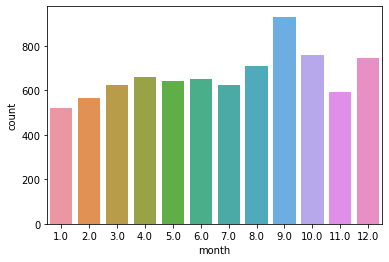

In [39]:
sns.countplot(x='month',data=train_data)

September is the most popular month for movie releases

<AxesSubplot:xlabel='day', ylabel='count'>

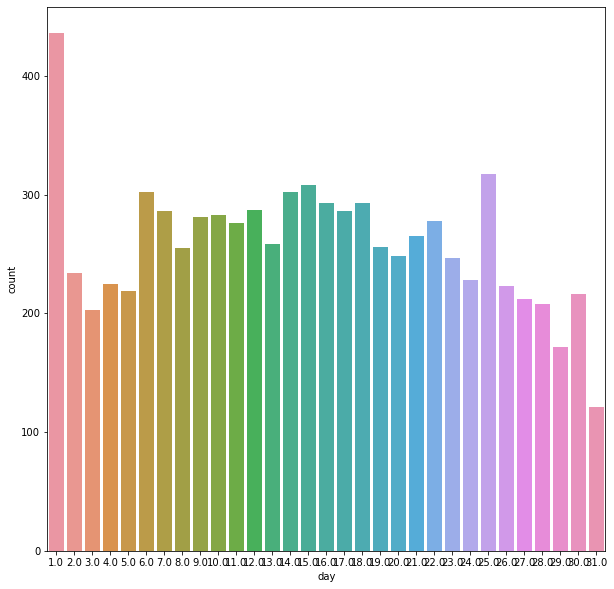

In [40]:
#Lets see about the beginning or ending of the month?
plt.figure(figsize=(10,10))
sns.countplot(x='day',data=train_data)

In [41]:
train_data['year'].unique()

array([2015., 2004., 2014., 2012., 2009., 1987., 1996., 2003., 1976.,
       1999., 2005., 2002., 2010., 2013., 2011., 1998., 1982., 2006.,
       1992., 1997., 1986., 2007., 2000., 1995., 2065., 2067., 2017.,
       1994., 2008., 1980., 1988., 2016., 1993., 2056., 1989., 2062.,
       1990., 1981., 1984., 1979., 2001., 2066., 1978., 2068., 1983.,
       1975., 1985., 1991., 2028., 2069., 2033., 2049., 2070., 2071.,
       1977., 2040., 2054., 2057., 2053., 2032., 2060., 2048., 2058.,
       2061., 2059., 2052., 2044., 2055., 2051., 1973., 1972., 2036.,
       2031., 2035., 2042., 2027., 2064., 2039., 2025., 2050., 2045.,
       2043., 1974., 2021., 2063., 2038., 2047., 2030., 2026., 2024.,
       2034., 2041.,   nan, 2037., 2029., 2046., 2018., 2023., 2022.])

In [42]:
# we can see the year column is incorrect
#fix it with 
train_data['year'] = train_data['release_date'].apply(lambda t: t.year if t.year < 2018 else t.year -100)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]),
 [Text(0, 0, '1918.0'),
  Text(1, 0, '1921.0'),
  Text(2, 0, '1922.0'),
  Text(3, 0, '1923.0'),
  Text(4, 0, '1924.0'),
  Text(5, 0, '1925.0'),
  Text(6, 0, '1926.0'),
  Text(7, 0, '1927.0'),
  Text(8, 0, '1928.0'),
  Text(9, 0, '1929.0'),
  Text(10, 0, '1930.0'),
  Text(11, 0, '1931.0'),
  Text(12, 0, '1932.0'),
  Text(13, 0, '1933.0'),
  Text(14, 0, '1934.0'),
  Text(15, 0, '1935.0'),
  Text(16, 0, '1936.0'),
  Text(17, 0, '1937.0'),
  Text(18, 0, '1938.0'),
  Text(19, 0, '1939.0'),
  Text(20, 0, '1940.0'),
  Text(21, 0, '1941.0'),
  Text(22, 0, '194

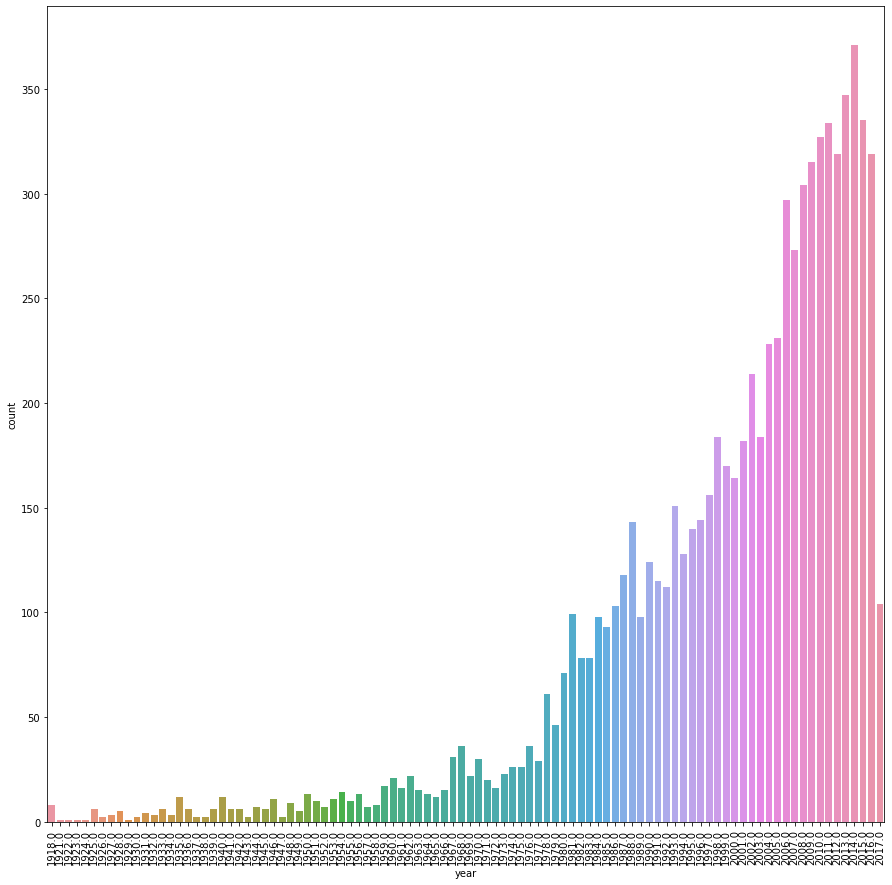

In [43]:
#release year popularity?
plt.figure(figsize=(15,15))
sns.countplot(x='year',data=train_data)
plt.xticks(rotation=90)

Text(0, 0.5, 'mean revenue')

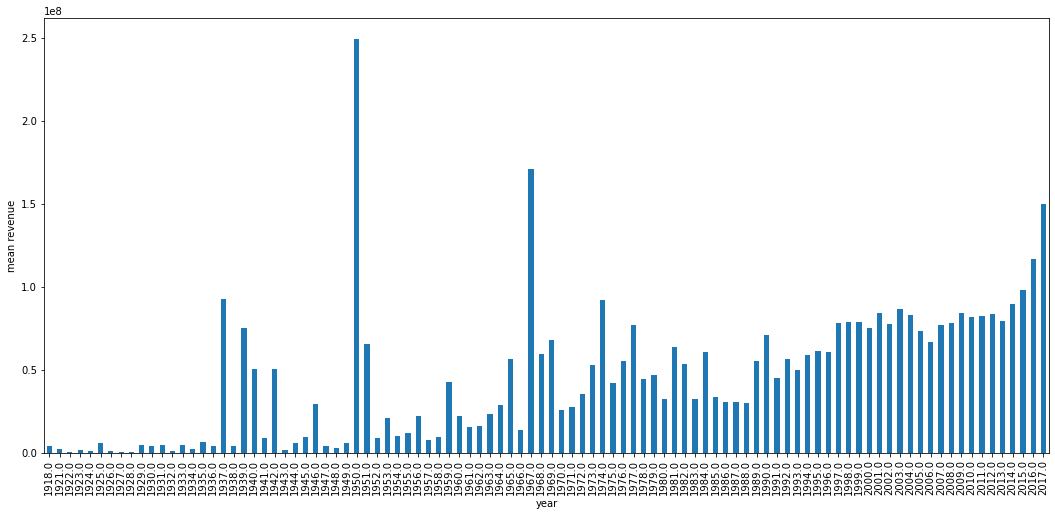

In [44]:
#see how data affects revenue
plt.figure(figsize = (18,8))
train_data.groupby(by = 'year')['revenue'].mean().plot.bar()
plt.ylabel('mean revenue')

Text(0, 0.5, 'mean revenue')

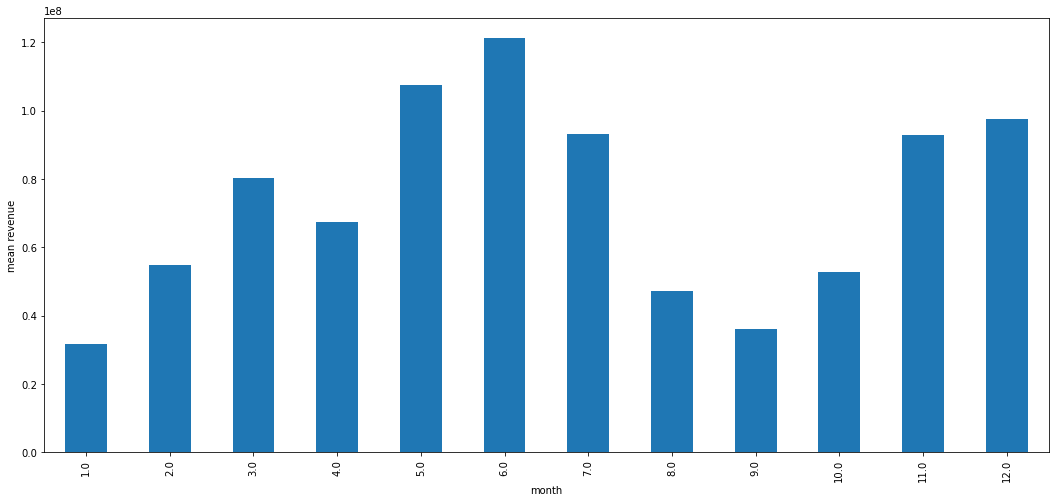

In [45]:
#by month 
plt.figure(figsize = (18,8))
train_data.groupby(by = 'month')['revenue'].mean().plot.bar()
plt.ylabel('mean revenue')

Text(0, 0.5, 'mean revenue')

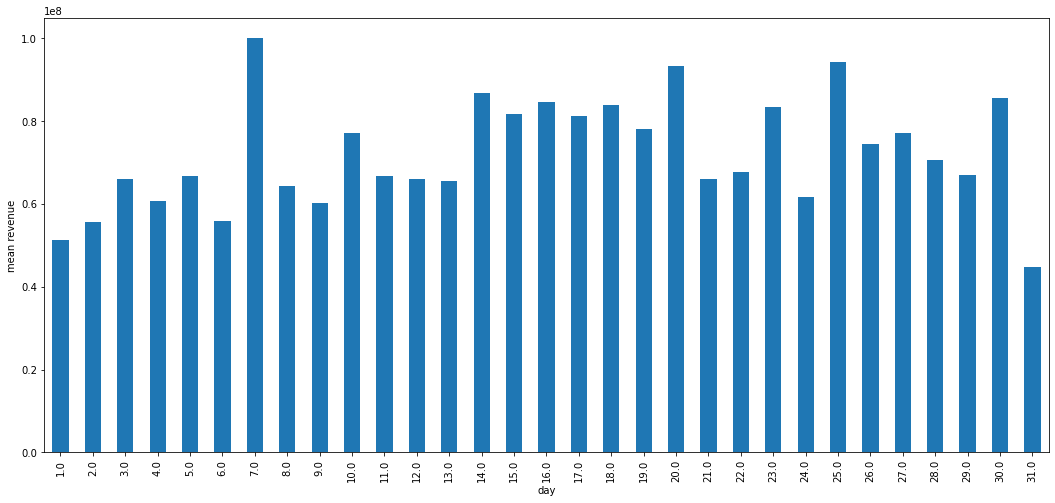

In [46]:
#may and june are the months when films rake in the most revenue 
#summer movies
plt.figure(figsize = (18,8))
train_data.groupby(by = 'day')['revenue'].mean().plot.bar()
plt.ylabel('mean revenue')

In [47]:
#adding column for day of the week 
train_data['day_of_the_week'] = train_data['release_date'].dt.dayofweek

# Status

<AxesSubplot:xlabel='status'>

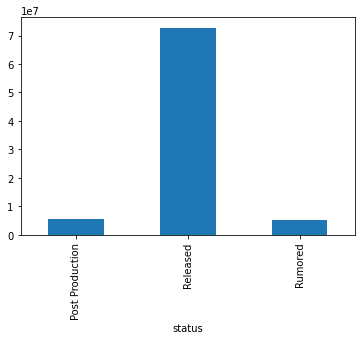

In [48]:
train_data.groupby(by = 'status')['revenue'].mean().plot.bar()

In [49]:
#pretty simple fix here 
train_data['Released'] = np.where(train_data['status'] == 'Released' , 1 , 0)
train_data['Rumoured'] = np.where(train_data['status'] == 'Rumoured' , 1 , 0)

# Features we will NOT be using:
- Imdb_id
- Original_title
- Overview
- Cast
- Crew 
- Keywords

# Pre-Processing: Addressing missing values

In [50]:
train_data.isna().sum()

id                          0
belongs_to_collection    6371
budget                      0
genres                     21
homepage                 5412
                         ... 
week                        1
day                         1
day_of_the_week             1
Released                    0
Rumoured                    0
Length: 119, dtype: int64

In [51]:
len(train_data[train_data['budget'] == 0])

2117

In [54]:
df_mean = train_data["budget"].mean()

In [56]:
train_data["budget"] = train_data["budget"].mask(train_data["budget"] == 0, df_mean)

In [57]:
len(train_data[train_data['budget'] == 0])

0

In [60]:
df = train_data.drop_duplicates(subset='title', keep='first')

In [61]:
df

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection,Comedy,Drama,Family,Romance,Thriller,Action,Animation,Adventure,Horror,Documentary,Music,Crime,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,TV Movie,is_homepage,is_original_language_english,English,हिन्दी,한국어/조선말,العربية,Pусский,svenska,Srpski,Deutsch,Français,Italiano,日本語,עִבְרִית,Português,Latin,普通话,Español,Nederlands,广州话 / 廣州話,,Český,தமிழ்,తెలుగు,Polski,Türkçe,Magyar,ελληνικά,Gaeilge,فارسی,ภาษาไทย,Català,Dansk,বাংলা,қазақ,Afrikaans,ਪੰਜਾਬੀ,български език,Kiswahili,Norsk,No Language,suomi,اردو,shqip,Română,Bahasa indonesia,Tiếng Việt,Slovenčina,Український,Esperanto,euskera,isiZulu,Somali,Íslenska,Wolof,Eesti,پښتو,Hrvatski,ქართული,Bosanski,Bamanankan,Galego,Cymraeg,?????,Malti,numer_of_spoken_languages,number_of_pc,is_production_country_US,year,month,week,day,day_of_the_week,Released,Rumoured
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",1.400000e+07,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-02-20,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0,2015.0,2.0,8.0,20.0,4.0,1,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",4.000000e+07,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-08-06,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0,2004.0,8.0,32.0,6.0,4.0,1,0
2,3,NaN,3.300000e+06,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2014-10-10,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0,2014.0,10.0,41.0,10.0,4.0,1,0
3,4,NaN,1.200000e+06,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",2012-03-09,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'

In [63]:
len(df[df['runtime'] == 0])

20

In [64]:
run_df = df.copy()
for i in run_df.index:
    if run_df.loc[i]['runtime'] < 60:
        run_df.at[i,'runtime_group'] = 1
    elif (run_df.loc[i]['runtime'] > 60) & (run_df.loc[i]['runtime'] < 120):
        run_df.at[i,'runtime_group'] = 2
    else:
        run_df.at[i,'runtime_group'] = 3

<AxesSubplot:xlabel='runtime_group'>

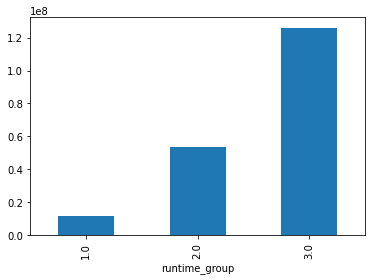

In [65]:
#view our categories
run_df.groupby(by = 'runtime_group')['revenue'].mean().plot.bar()

In [66]:
df['runtime_group'] = run_df['runtime_group']

<ipython-input-66-a1053c56b874>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['runtime_group'] = run_df['runtime_group']


In [67]:
#drop unusable columns 
drop_columns = ['id','crew', 'cast' , 'Keywords', 'title', 'tagline', 'status', 'spoken_languages', 'runtime', 'release_date', 'production_countries', 'production_companies', 'poster_path', 'overview', 'original_title', 'original_language', 'imdb_id', 'homepage', 'genres', 'belongs_to_collection']
df.drop(drop_columns , axis = 1 , inplace = True)

/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [68]:
df.head()

,budget,popularity,revenue,collection,Comedy,Drama,Family,Romance,Thriller,Action,Animation,Adventure,Horror,Documentary,Music,Crime,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,TV Movie,is_homepage,is_original_language_english,English,हिन्दी,한국어/조선말,العربية,Pусский,svenska,Srpski,Deutsch,Français,Italiano,日本語,עִבְרִית,Português,Latin,普通话,Español,Nederlands,广州话 / 廣州話,,Český,தமிழ்,తెలుగు,Polski,Türkçe,Magyar,ελληνικά,Gaeilge,فارسی,ภาษาไทย,Català,Dansk,বাংলা,қазақ,Afrikaans,ਪੰਜਾਬੀ,български език,Kiswahili,Norsk,No Language,suomi,اردو,shqip,Română,Bahasa indonesia,Tiếng Việt,Slovenčina,Український,Esperanto,euskera,isiZulu,Somali,Íslenska,Wolof,Eesti,پښتو,Hrvatski,ქართული,Bosanski,Bamanankan,Galego,Cymraeg,?????,Malti,numer_of_spoken_languages,number_of_pc,is_production_country_US,year,month,week,day,day_of_the_week,Released,Rumoured,runtime_group
0,1.400000e+07,6.575393,12314651,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0,2015.0,2.0,8.0,20.0,4.0,1,0,2.0
1,4.000000e+07,8.248895,95149435,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0,2004.0,8.0,32.0,6.0,4.0,1,0,2.0
2,3.300000e+06,64.299990,13092000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0,2014.0,10.0,41.0,10.0,4.0,1,0,2.0
3,1.200000e+06,3.174936,16000000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0.0,2012.0,3.0,10.0,9.0,4.0,1,0,3.0
4,2.312810e+07,1.148070,3923970,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,2009.0,2.0,6.0,5.0,3.0,1,0,2.0


In [75]:
df.isna().sum()

budget             0
popularity         0
revenue            0
collection         0
Comedy             0
                  ..
day                1
day_of_the_week    1
Released           0
Rumoured           0
runtime_group      0
Length: 100, dtype: int64

In [76]:
df.dropna(inplace=True)

<ipython-input-76-c64f9f573c18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import string

# Split Data
- Do a test train split for modeling

In [77]:
train , test = train_test_split(df , test_size = 0.2)

In [78]:
#identifying target and feature variables
# This is the training feature dataset.
X_train = train.drop('revenue' , axis = 1)
# This is the training label set.
Y_train = train['revenue']
# This is the test feature dataset.
X_test = test.drop('revenue' , axis = 1)
# This is the test label set.
Y_test = test['revenue']

# SCALE DATA

In [79]:
#scale our data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# We have to use the same scaler to transform the test set as this will use the same parameter calculated for the training set
# to tranform the test set.
X_test = scaler.transform(X_test)

# Model
RandomForestRegressor: a Regressor is used to predict real valued outputs which vary and dont require outputs predicted to be in a fixed set. RandomForestClassifier: A Classifier is used to predict a set of specified labels


In [80]:
#randomforestregressor with default params
regressor = RandomForestRegressor(n_jobs = -1)
regressor.fit(X_train,Y_train)

RandomForestRegressor(n_jobs=-1)

In [81]:
Y_pred = regressor.predict(X_test)

In [82]:
msle = mean_squared_log_error(Y_test , Y_pred)
rmse = np.sqrt(msle)

print("The Root-Mean-Squared-Logarithmic-Error of the untuned model is : " + str(rmse))


The Root-Mean-Squared-Logarithmic-Error of the untuned model is : 2.563361960565136


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]),
 [Text(0, 0, 'budget'),
  Text(1, 0, 'popularity'),
  Text(2, 0, 'collection'),
  Text(3, 0, 'Comedy'),
  Text(4, 0, 'Drama'),
  Text(5, 0, 'Family'),
  Text(6, 0, 'Romance'),
  Text(7, 0, 'Thriller'),
  Text(8, 0, 'Action'),
  Text(9, 0, 'Animation'),
  Text(10, 0, 'Adventure'),
  Text(11, 0, 'Horror'),
  Text(12, 0, 'Documentary'),
  Text(13, 0, 'Music'),
  Text(14, 0, 'Crime'),
  Text(15, 0, 'Science Fiction'),
  Text(16, 0, 'Mystery'),
  Text(17, 0, 'Foreign'),
  Text(18, 0, 'Fantasy'),
  Text(19, 0, 'War'),
  Text(20, 0, 'Western'),
  Text(21,

/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2367 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2342 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/meredithgray/opt/anaconda3/l

/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 2367 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 2381 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 2342 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/meredithgray/opt/anaconda3/lib/python3

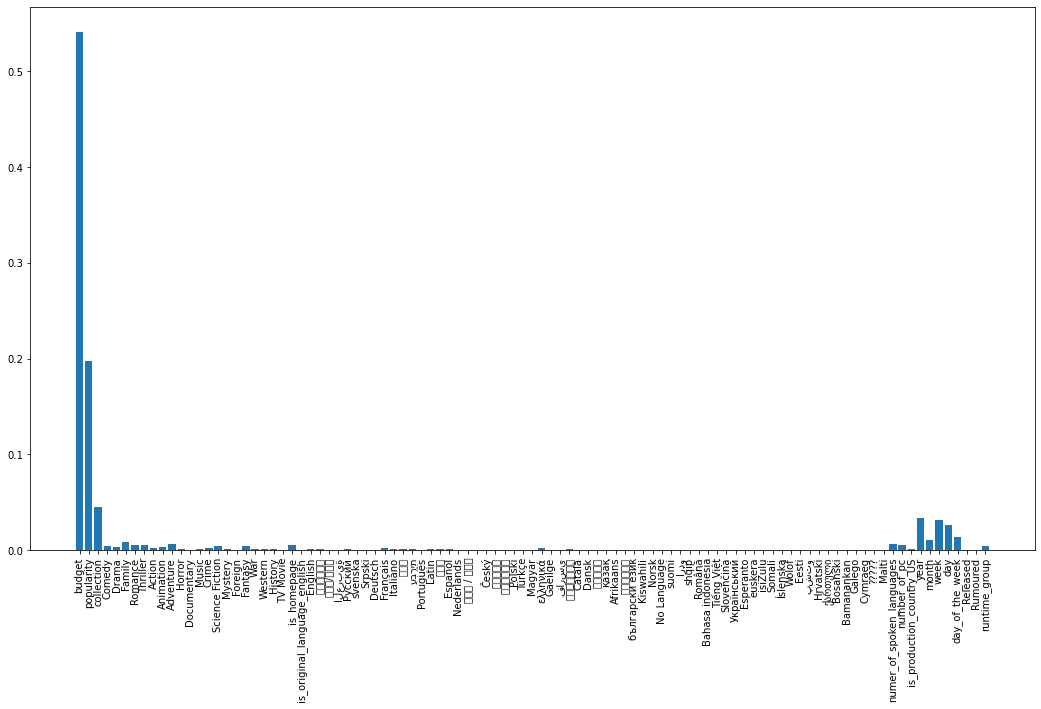

In [83]:
#interested in seeing the features that contribute the most 
plt.figure(figsize = (18,10))
plt.bar(range(len(regressor.feature_importances_)), regressor.feature_importances_ , tick_label = train.drop('revenue', axis = 1).columns)
plt.xticks(rotation = 90)

# Budget and Popularity

# Tuning the RandomForestRegressor
use the RandomizeSearchCV and GridSearchCV 

In [84]:
# Number of Trees in the Random Forest Regressor
n_estimators = [int(x) for x in np.linspace(10,300,30)]
# Number of features to consider while splitting
max_features = ['auto' , 'sqrt' , 'log2']
# Maximum Depth of the tree
max_depth = [int(x) for x in np.linspace(20,200,20)]
# The minimum number of samples required to split an internal node.
min_samples_split = [int(x) for x in np.linspace(10,500,50)]
# The minimum number of samples required to be at a leaf node
min_samples_leaf = [int(x) for x in np.linspace(50,100,10)]
# True then bootstrap samples are used(smaller sample taken from the entire dataset) , False then the entire dataset is used.
bootstrap = ['True' , 'False']

param_random = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth'    : max_depth,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf,
    'bootstrap'    : bootstrap
}

In [85]:
regressor_random = RandomForestRegressor()

regressor_random_grid = RandomizedSearchCV(estimator = regressor_random , 
                                           param_distributions = param_random , 
                                           n_iter = 30 ,
                                           cv = 10, 
                                           scoring = 'neg_mean_squared_log_error',
                                           verbose = 2 ,
                                           n_jobs = -1
                                          )


In [86]:
regressor_random_grid.fit(X_train, Y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'bootstrap': ['True', 'False'],
                                        'max_depth': [20, 29, 38, 48, 57, 67,
                                                      76, 86, 95, 105, 114, 124,
                                                      133, 143, 152, 162, 171,
                                                      181, 190, 200],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [50, 55, 61, 66, 72,
                                                             77, 83, 88, 94,
                                                             100],
                                        'min_samples_split': [10, 20, 30, 40,
                                                              50, 60, 70, 80

In [87]:
print('Best Paramters : ' + str(regressor_random_grid.best_params_))

Best Paramters : {'n_estimators': 30, 'min_samples_split': 110, 'min_samples_leaf': 66, 'max_features': 'auto', 'max_depth': 200, 'bootstrap': 'False'}


In [88]:
print('Best Score : ' + str(np.sqrt(-regressor_random_grid.best_score_)))

Best Score : 2.8677641018525795


In [89]:
print('Best Estimator : ' + str(regressor_random_grid.best_estimator_))

Best Estimator : RandomForestRegressor(bootstrap='False', max_depth=200, min_samples_leaf=66,
                      min_samples_split=110, n_estimators=30)


In [90]:
Y_pred_random = regressor_random_grid.best_estimator_.predict(X_test)
msle = mean_squared_log_error(Y_test , Y_pred_random)
rmse = np.sqrt(msle)

print("The Root-Mean-Squared-Logarithmic-Error using the best estimator found using Randomized Search CV is : " + str(rmse))

The Root-Mean-Squared-Logarithmic-Error using the best estimator found using Randomized Search CV is : 2.69919153718022


In [91]:
# Number of Trees in the Random Forest Regressor
n_estimators = [int(x) for x in np.linspace(100,200,5)]
# Number of features to consider while splitting
max_features = ['auto']
# Maximum Depth of the tree. We will keep the default value
# The minimum number of samples required to split an internal node.
min_samples_split = [int(x) for x in np.linspace(2,20,5)]
# The minimum number of samples required to be at a leaf node
min_samples_leaf = [int(x) for x in np.linspace(1,10,5)]
# True then bootstrap samples are used(smaller sample taken from the entire dataset) , False then the entire dataset is used.
bootstrap = ['True']

param_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf,
    'bootstrap'    : bootstrap
}


In [92]:
regressor_grid = RandomForestRegressor()

regressor_grid_search = GridSearchCV(estimator = regressor_grid , 
                                     param_grid = param_grid , 
                                     cv = 3 , 
                                     scoring = 'neg_mean_squared_log_error',
                                     verbose = 2 ,
                                     n_jobs = -1
                                    )


In [93]:
regressor_grid_search.fit(X_train , Y_train)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': ['True'], 'max_features': ['auto'],
                         'min_samples_leaf': [1, 3, 5, 7, 10],
                         'min_samples_split': [2, 6, 11, 15, 20],
                         'n_estimators': [100, 125, 150, 175, 200]},
             scoring='neg_mean_squared_log_error', verbose=2)

In [94]:
print('Best Paramters : ' + str(regressor_grid_search.best_params_))

Best Paramters : {'bootstrap': 'True', 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 11, 'n_estimators': 100}


In [95]:
print('Best Score : ' + str(np.sqrt(-regressor_grid_search.best_score_)))

Best Score : 2.763193286017594


In [96]:
Y_pred_grid = regressor_grid_search.best_estimator_.predict(X_test)
msle = mean_squared_log_error(Y_test , Y_pred_grid)
rmse = np.sqrt(msle)

print("The Root-Mean-Squared-Logarithmic-Error using the best estimator found using Grid Search CV is : " + str(rmse))


The Root-Mean-Squared-Logarithmic-Error using the best estimator found using Grid Search CV is : 2.550253800963742


# Best Results:The Root-Mean-Squared-Logarithmic-Error using the best estimator found using Randomized Search CV is : 2.69919153718022

# Random Forest Regressor Score 

In [97]:
randomForestRegressor = RandomForestRegressor(random_state=0)
randomForestRegressor.fit(X_train, Y_train)
print("RandomForestRegressor score: ", randomForestRegressor.score(X_test,Y_test))

RandomForestRegressor score:  0.6928407932186352


In [100]:
#adjusting hyperparams
randomForestRegressor_scaled = RandomForestRegressor(n_estimators= 30, min_samples_split= 110, 
                                                     min_samples_leaf= 66, 
                                                    max_depth= 200, 
                                                     bootstrap=False)
randomForestRegressor_scaled.fit(X_train, Y_train)
print("RandomForestRegressor scaled score: ", randomForestRegressor_scaled.score(X_test, Y_test))

RandomForestRegressor scaled score:  0.6201044727932143


# Default Params give best results with a score of 0.6928

In [101]:
#looking at score 
regressor = RandomForestRegressor(n_estimators = 1000, random_state = 42)
regressor.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [102]:
y_pred = regressor.predict(X_test)

In [104]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

Mean Absolute Error: 37995318.2219733
Mean Squared Error: 8093687706932353.0
Root Mean Squared Error: 89964924.87037575


In [105]:
# Calculate the absolute errors
errors = abs(y_pred - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 37995318.22 degrees.
Accuracy: -inf %.


/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


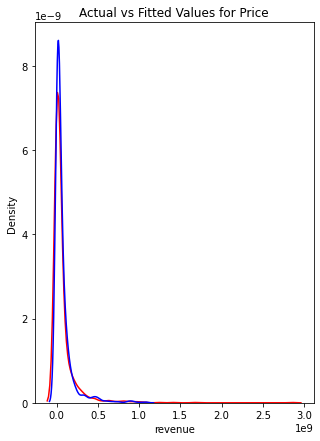

In [108]:
plt.figure(figsize=(5, 7))


ax = sns.distplot(Y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values for Price')


plt.show()
plt.close()

# Linear Regression Model

In [110]:
from sklearn.linear_model import LinearRegression

In [111]:
lr_ = LinearRegression()
lr_.fit(X_train,Y_train)
pred = lr_.predict(X_test)

In [112]:
def rmsle(y_true, y_pred):
    return 'rmsle', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

In [113]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(Y_test, pred))
print('MSE:', metrics.mean_squared_error(Y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, pred)))
print('RMSLE:', rmsle(Y_test, pred))

MAE: 50287402.30889202
MSE: 9417988894785278.0
RMSE: 97046323.44805896
RMSLE: ('rmsle', 2.7684704471454937, False)


<ipython-input-112-b98b27b53830>:2: RuntimeWarning: invalid value encountered in log1p
  return 'rmsle', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False


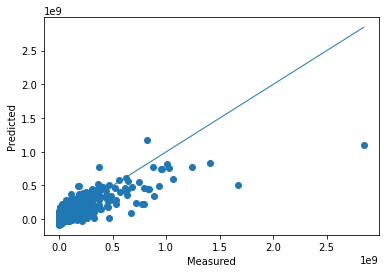

In [115]:
fig, ax = plt.subplots()
ax.scatter(Y_test, pred)
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# Considering Multiple Models

In [116]:
def test_model(model, data):
    X_train, X_test, Y_train, Y_test = data
    reg = model.fit(X_train, Y_train)
    print(f'Model: {type(reg).__name__}')
    print(f'Train score: {reg.score(X_train, Y_train)}')
    print(f'Test Score: {reg.score(X_test, Y_test)}\n')
    plt.show()    

In [119]:
data= X_train, X_test, Y_train, Y_test

In [117]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [120]:
test_model(LinearRegression(), data)

test_model(KNeighborsRegressor(), data)
test_model(RandomForestRegressor(), data)
test_model(ExtraTreesRegressor(), data)
test_model(AdaBoostRegressor(), data)
test_model(SVR(C=1.0, epsilon=0.2), data)

Model: LinearRegression
Train score: 0.6457683839662829
Test Score: 0.6461107192689071

Model: KNeighborsRegressor
Train score: 0.6977333398901868
Test Score: 0.5589850933800602

Model: RandomForestRegressor
Train score: 0.9596791591551299
Test Score: 0.6964328857740774

Model: ExtraTreesRegressor
Train score: 1.0
Test Score: 0.699168334370003

Model: AdaBoostRegressor
Train score: 0.2069849268832017
Test Score: 0.27026968232256965

Model: SVR
Train score: -0.13517775682919697
Test Score: -0.10200536681246786



In [121]:
randomForestRegressor = RandomForestRegressor(random_state=0,n_estimators= 30, min_samples_split= 110, 
                                                     min_samples_leaf= 66, 
                                                    max_depth= 200, 
                                                     bootstrap=False)
randomForestRegressor.fit(X_train, Y_train)
print("RandomForestRegressor score: ", randomForestRegressor.score(X_train,Y_train))

RandomForestRegressor score:  0.67915637040395


In [122]:
randomForestRegressor = RandomForestRegressor(random_state=0,n_estimators= 30, min_samples_split= 110, 
                                                     min_samples_leaf= 66, 
                                                    max_depth= 200, 
                                                     bootstrap=False)
randomForestRegressor.fit(X_train, Y_train)
print("RandomForestRegressor score: ", randomForestRegressor.score(X_test,Y_test))

RandomForestRegressor score:  0.6201044727932143


# Conclusion

# The RandomForest Regressor is the best model for this prediction w/ a test score of 0.67915637040395 and a train score of 0.6201044727932143
We tuned the parameters and ended with random_state=0,n_estimators= 30, min_samples_split= 110, 
                                                     min_samples_leaf= 66, 
                                                    max_depth= 200, 
                                                     bootstrap=False

In [123]:
df

,budget,popularity,revenue,collection,Comedy,Drama,Family,Romance,Thriller,Action,Animation,Adventure,Horror,Documentary,Music,Crime,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,TV Movie,is_homepage,is_original_language_english,English,हिन्दी,한국어/조선말,العربية,Pусский,svenska,Srpski,Deutsch,Français,Italiano,日本語,עִבְרִית,Português,Latin,普通话,Español,Nederlands,广州话 / 廣州話,,Český,தமிழ்,తెలుగు,Polski,Türkçe,Magyar,ελληνικά,Gaeilge,فارسی,ภาษาไทย,Català,Dansk,বাংলা,қазақ,Afrikaans,ਪੰਜਾਬੀ,български език,Kiswahili,Norsk,No Language,suomi,اردو,shqip,Română,Bahasa indonesia,Tiếng Việt,Slovenčina,Український,Esperanto,euskera,isiZulu,Somali,Íslenska,Wolof,Eesti,پښتو,Hrvatski,ქართული,Bosanski,Bamanankan,Galego,Cymraeg,?????,Malti,numer_of_spoken_languages,number_of_pc,is_production_country_US,year,month,week,day,day_of_the_week,Released,Rumoured,runtime_group
0,1.400000e+07,6.575393,12314651,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0,2015.0,2.0,8.0,20.0,4.0,1,0,2.0
1,4.000000e+07,8.248895,95149435,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0,2004.0,8.0,32.0,6.0,4.0,1,0,2.0
2,3.300000e+06,64.299990,13092000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0,2014.0,10.0,41.0,10.0,4.0,1,0,2.0
3,1.200000e+06,3.174936,16000000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0.0,2012.0,3.0,10.0,9.0,4.0,1,0,3.0
4,2.312810e+07,1.148070,3923970,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,2009.0,2.0,6.0,5.0,3.0,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8014,4.200000e+07,9.970359,35402320,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,2,1.0,2001.0,8.0,31.0,3.0,4.0,1,0,2.0
8015,1.900000e+07,6.046516,69631118,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0,2004.0,8.0,34.0,20.0,4.0,1,0,2.0
8016,1.600000e+07,9.596883,53977250,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0,1982.0,12.0,49.0,8.0,2.0,1,0,3.0
8017,2.000000e+06,20.359336,14674076,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0,2015.0,2.0,6.0,4.0,2.0,1,0,2.0
